# Only use the first 1001 columns for calculating the cov matrix

In [2]:
import dask.dataframe as dd
import numpy as np
from scipy.sparse import lil_matrix, vstack
from tqdm import tqdm

def create_location_mapping(df):
    locations = df[0].unique()  
    location_mapping = {location: idx for idx, location in enumerate(locations)}  
    return location_mapping

def base_to_index(base):
    base_map = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    return base_map.get(base, -1)  # If not of base ACGT, return -1

def process_data_to_sparse_matrix(df_chunk, location_mapping):
    num_locations = len(location_mapping)  # location
    num_bases = 4  # A, C, G, T
    num_columns = df_chunk.shape[1] - 2  # Others

    sparse_matrix = lil_matrix((num_locations * num_bases, num_columns))

    for idx, row in df_chunk.iterrows():
        location = row[0]  
        base_idx = base_to_index(row[1])  
        frequencies = row[2:].values  

        if location not in location_mapping:
            raise KeyError(f"Location {location} not found in mapping!")
        
        location_idx = location_mapping[location]


        matrix_row_idx = location_idx * num_bases + base_idx
        sparse_matrix[matrix_row_idx, :] = frequencies  

    return sparse_matrix

def main():
    file_path = "select.freq.filtered"  

    df = dd.read_csv(file_path, header=None, sep="\t", dtype={0: 'object', 1: 'object'}, usecols=range(1001), blocksize=10e6)


    location_mapping = None
    location_set = set()

    for df_chunk in tqdm(df.to_delayed(), desc="Scanning Locations"):

        df_chunk = df_chunk.compute()


        location_set.update(df_chunk[0].unique())  #  update location set


    location_mapping = {location: idx for idx, location in enumerate(sorted(location_set))}


    sparse_matrices = []
    for df_chunk in tqdm(df.to_delayed(), desc="Processing Data Chunks"):

        df_chunk = df_chunk.compute()

        sparse_matrix = process_data_to_sparse_matrix(df_chunk, location_mapping)
        sparse_matrices.append(sparse_matrix)

    final_sparse_matrix = vstack(sparse_matrices)

    print("Successfully building the sparse matrix!")

    from scipy.sparse import save_npz
    save_npz('sparse_matrix.npz', final_sparse_matrix)

if __name__ == "__main__":
    main()


Processing Data Chunks: 100%|██████████████████████████████████████████████████████████| 59/59 [00:27<00:00,  2.16it/s]

Successfully building the sparse matrix!


# Calculate the cov matrix via these selected data, and then PCA

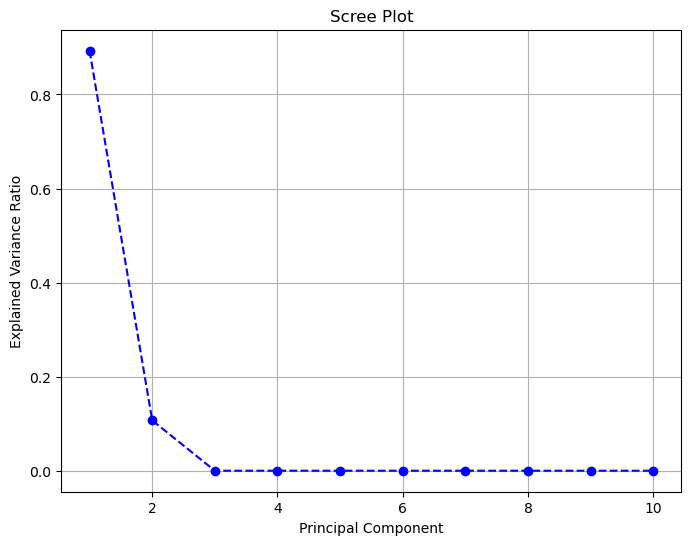

Top k Eigenvalues and Explained Variance Ratio:
PC1: Eigenvalue = 12860.0283, Explained Variance Ratio = 0.8930
PC2: Eigenvalue = 1540.7592, Explained Variance Ratio = 0.1070
PC3: Eigenvalue = 0.0000, Explained Variance Ratio = 0.0000
PC4: Eigenvalue = 0.0000, Explained Variance Ratio = 0.0000
PC5: Eigenvalue = 0.0000, Explained Variance Ratio = 0.0000
PC6: Eigenvalue = 0.0000, Explained Variance Ratio = 0.0000
PC7: Eigenvalue = 0.0000, Explained Variance Ratio = 0.0000
PC8: Eigenvalue = 0.0000, Explained Variance Ratio = 0.0000
PC9: Eigenvalue = 0.0000, Explained Variance Ratio = 0.0000
PC10: Eigenvalue = 0.0000, Explained Variance Ratio = 0.0000


ValueError: shapes (15104,999) and (3996,10) not aligned: 999 (dim 1) != 3996 (dim 0)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import load_npz

def pca_analysis(cov_matrix, location_data, k=10):
    """
    Perform PCA on the covariance matrix and plot the scree plot for explained variance.
    
    Parameters:
    cov_matrix (np.ndarray): Covariance matrix of the data
    location_data (np.ndarray): Original data (before PCA)
    k (int): Number of principal components to keep (default 10)
    
    Returns:
    np.ndarray: Projected data in the top k principal components
    """
    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Select top k eigenvectors
    selected_eigenvectors = sorted_eigenvectors[:, :k]
    
    # Compute explained variance ratio
    explained_variance_ratio = sorted_eigenvalues[:k] / sorted_eigenvalues.sum()
    
    # Scree plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, k + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)
    plt.show()

    # Print eigenvalues and explained variance ratio
    print("Top k Eigenvalues and Explained Variance Ratio:")
    for i in range(k):
        print(f"PC{i+1}: Eigenvalue = {sorted_eigenvalues[i]:.4f}, Explained Variance Ratio = {explained_variance_ratio[i]:.4f}")
    
    # Project original data onto the top k principal components
    projected_data = location_data.dot(selected_eigenvectors)
    
    return projected_data

# Load the sparse matrix from the .npz file (use load_npz for sparse matrices)
sparse_matrix = load_npz('sparse_matrix.npz')  # Loading the sparse matrix saved as .npz

# Compute covariance matrix if you haven't already
cov_matrix = np.load('location_covariance_matrix.npy')  # Load the covariance matrix

# Perform PCA and keep top 10 principal components
projected_data = pca_analysis(cov_matrix, sparse_matrix.toarray(), k=10)

# Save the projected data
np.save('projected_data.npy', projected_data)
print("PCA completed and projected data saved as 'projected_data.npy'")


## One location has four possible bases ACGT, so we might consider combine them all together(?)

Combined Location Data shape: (3776, 999)
Covariance matrix shape: (999, 999)


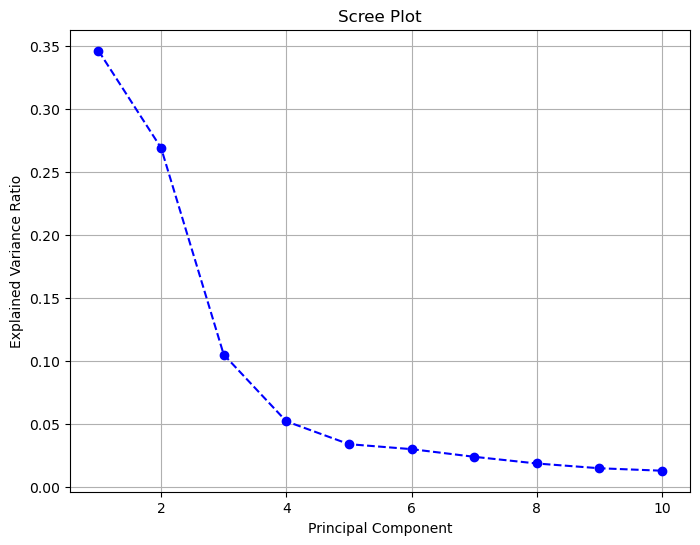

Top k Eigenvalues and Explained Variance Ratio:
PC1: Eigenvalue = 2668.4404, Explained Variance Ratio = 0.3460
PC2: Eigenvalue = 2074.2171, Explained Variance Ratio = 0.2689
PC3: Eigenvalue = 810.8646, Explained Variance Ratio = 0.1051
PC4: Eigenvalue = 402.7330, Explained Variance Ratio = 0.0522
PC5: Eigenvalue = 263.0450, Explained Variance Ratio = 0.0341
PC6: Eigenvalue = 232.6297, Explained Variance Ratio = 0.0302
PC7: Eigenvalue = 185.8531, Explained Variance Ratio = 0.0241
PC8: Eigenvalue = 144.9468, Explained Variance Ratio = 0.0188
PC9: Eigenvalue = 115.8545, Explained Variance Ratio = 0.0150
PC10: Eigenvalue = 100.7727, Explained Variance Ratio = 0.0131
PCA completed and projected data saved as 'projected_data_combined.npy'


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import load_npz

def combine_base_frequencies(location_data):
    """
    Combine the frequencies of all bases (A, C, G, T) into a single entry per location.
    
    Parameters:
    location_data (np.ndarray): The original data with shape (num_locations * 4, num_columns)
    
    Returns:
    np.ndarray: The data with shape (num_locations, num_columns)
    """
    num_locations = location_data.shape[0] // 4
    combined_data = location_data.reshape(num_locations, 4, -1).sum(axis=1)  # Sum over bases (axis 1)
    return combined_data

def pca_analysis(cov_matrix, location_data, k=10):
    """
    Perform PCA on the covariance matrix and plot the scree plot for explained variance.
    
    Parameters:
    cov_matrix (np.ndarray): Covariance matrix of the data
    location_data (np.ndarray): Original data (before PCA)
    k (int): Number of principal components to keep (default 10)
    
    Returns:
    np.ndarray: Projected data in the top k principal components
    """
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    selected_eigenvectors = sorted_eigenvectors[:, :k]
    
    # explained
    explained_variance_ratio = sorted_eigenvalues[:k] / sorted_eigenvalues.sum()
    
    # Scree plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, k + 1), explained_variance_ratio, marker='o', linestyle='--', color='b')
    plt.title('Scree Plot')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.grid(True)
    plt.show()

    
    print("Top k Eigenvalues and Explained Variance Ratio:")# Print eigenvalues and explained variance ratio
    for i in range(k):
        print(f"PC{i+1}: Eigenvalue = {sorted_eigenvalues[i]:.4f}, Explained Variance Ratio = {explained_variance_ratio[i]:.4f}")
    
    projected_data = location_data.dot(selected_eigenvectors)
    
    return projected_data


sparse_matrix = load_npz('sparse_matrix.npz') 

location_data = sparse_matrix.toarray()  # convert the sparse matrix to a dense np array

# Combine the frequencies of all bases (A, C, G, T)
combined_location_data = combine_base_frequencies(location_data)

# Verify the new shape of the combined data
print(f"Combined Location Data shape: {combined_location_data.shape}")

cov_matrix = np.cov(combined_location_data, rowvar=False)  
# Verify the shape (combined bases)
print(f"Covariance matrix shape: {cov_matrix.shape}")

projected_data = pca_analysis(cov_matrix, combined_location_data, k=10)

np.save('projected_data_combined.npy', projected_data)
print("PCA completed and projected data saved as 'projected_data_combined.npy'")


## Hence, we select first two PCs for an explained ratio of over 0.6

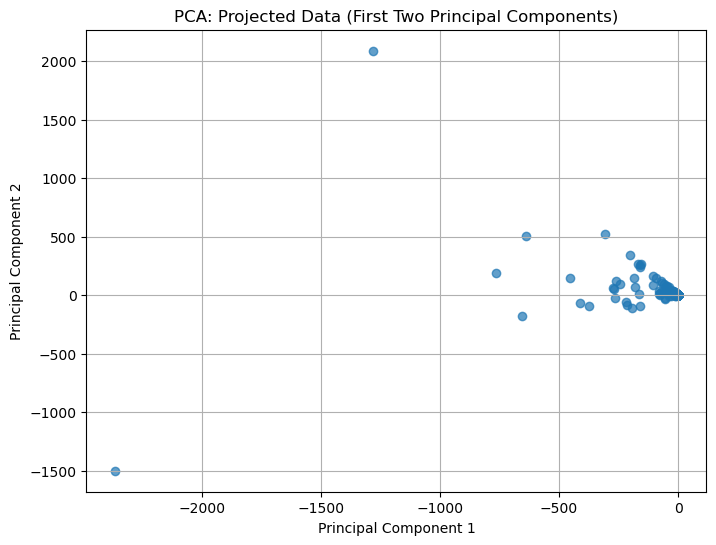

In [13]:
import matplotlib.pyplot as plt

# Load the projected data
projected_data = np.load('projected_data_combined.npy')

# Plot the first two principal components
plt.figure(figsize=(8, 6))
plt.scatter(projected_data[:, 0], projected_data[:, 1], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: Projected Data (First Two Principal Components)")
plt.grid(True)
plt.show()


### remove outliers and rerun

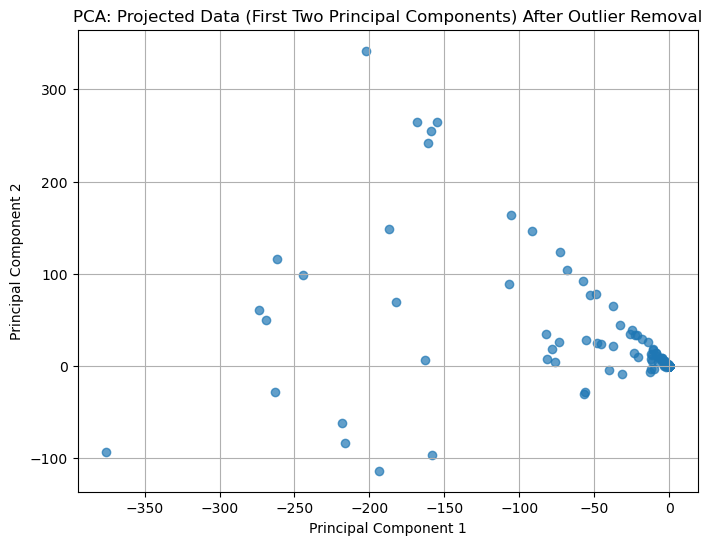

In [24]:
import numpy as np
import matplotlib.pyplot as plt

projected_data = np.load('projected_data_combined.npy')

threshold = 400

# Remove points where the absolute value of either principal component exceeds the threshold
filtered_data = projected_data[
    (np.abs(projected_data[:, 0]) <= threshold) & 
    (np.abs(projected_data[:, 1]) <= threshold)
]

plt.figure(figsize=(8, 6))
plt.scatter(filtered_data[:, 0], filtered_data[:, 1], alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA: Projected Data (First Two Principal Components) After Outlier Removal")
plt.grid(True)
plt.show()



In [25]:

print(f"Original data shape: {projected_data.shape}")
print(f"Filtered data shape: {filtered_data.shape}")

Original data shape: (3776, 10)
Filtered data shape: (3768, 10)


## K-means

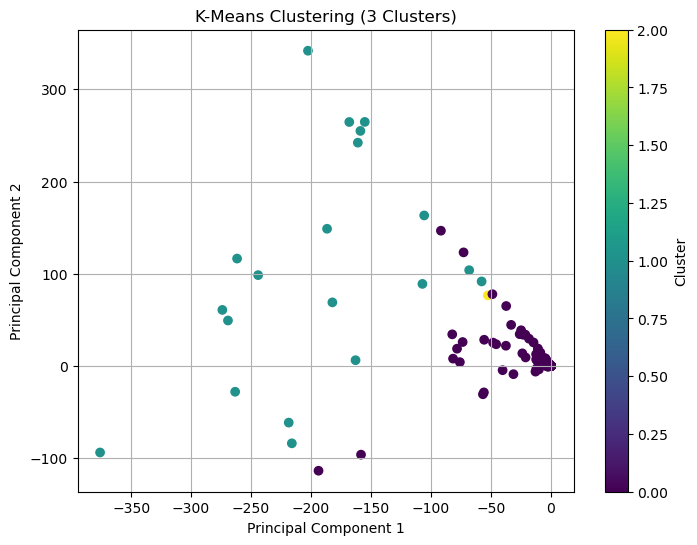

In [27]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


kmeans = KMeans(n_clusters=3, random_state=42) 
labels = kmeans.fit_predict(filtered_data) # FILTERED OUTLIERS


plt.figure(figsize=(8, 6))
plt.scatter(filtered_data[:, 0], filtered_data[:, 1], c=labels, cmap='viridis')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("K-Means Clustering (3 Clusters)")
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()
